In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from scipy.ndimage import gaussian_filter
plt.ion()

# PHYS 512 - Problem Set 4
Tristan Ménard<br>
260675783

In [3]:
# Read the LIGO data
# directory = 'C:/Users/Trix/Documents/GitHub/phys512-problem-sets/ProblemSet4/LOSC_Event_tutorial/LOSC_Event_tutorial/'
directory = 'C:/Users/trist/Documents/GitHub/phys512-problem-sets/ProblemSet4/LOSC_Event_tutorial/LOSC_Event_tutorial/'

def read_template(filename):
    dataFile = h5py.File(filename,'r')
    template = dataFile['template']
    th = template[0]
    tl = template[1]
    return th, tl

def read_file(filename):
    dataFile = h5py.File(filename, 'r')
    dqInfo = dataFile['quality']['simple']
    qmask = dqInfo['DQmask'][...]
    
    meta = dataFile['meta']
    gpsStart = meta['GPSstart'][()]
    utc = meta['UTCstart'][()]
    duration = meta['Duration'][()]
    strain = dataFile['strain']['Strain'][()]
    dt = (1.0*duration)/len(strain)
    
    dataFile.close()
    return strain, dt, utc

fname = 'H-H1_LOSC_4_V2-1126259446-32.hdf5'
print('Reading file', fname)
strain_H, dt_H, utc_H = read_file(directory+fname)

fname = 'L-L1_LOSC_4_V2-1126259446-32.hdf5'
print('Reading file', fname)
strain_L, dt_L, utc_L = read_file(directory+fname)

template_name = 'GW150914_4_template.hdf5'
print('Reading template', template_name)
th, tl = read_template(directory+template_name)

Reading file H-H1_LOSC_4_V2-1126259446-32.hdf5
Reading file L-L1_LOSC_4_V2-1126259446-32.hdf5
Reading template GW150914_4_template.hdf5


In [4]:
# Both Hanford and Livingston have the same sampling rate
dt = dt_L
samp = int(1/dt)
print('Use', samp, 'Hz sampling rate from file', fname)

Use 4096 Hz sampling rate from file L-L1_LOSC_4_V2-1126259446-32.hdf5


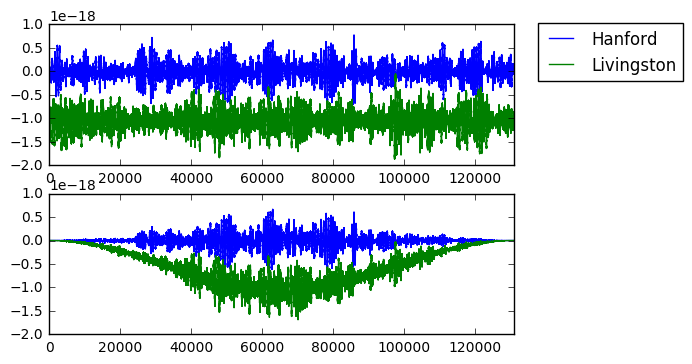

In [5]:
strain_H_win = strain_H*np.hanning(len(strain_H))
strain_L_win = strain_L*np.hanning(len(strain_L))

plt.subplot(2,1,1)
plt.plot(strain_H, label='Hanford')
plt.plot(strain_L, label='Livingston')
plt.xlim(0, len(strain_H))
plt.legend(loc=(1.05,0.6))

plt.subplot(2,1,2)
plt.plot(strain_H_win)
plt.plot(strain_L_win)
plt.xlim(0, len(strain_H))

plt.show()

In [6]:
noise_H = np.abs(np.fft.rfft(strain_H))**2
noise_L = np.abs(np.fft.rfft(strain_L))**2
freq = np.fft.rfftfreq(len(strain_H), dt)

noise_H_win = np.abs(np.fft.rfft(strain_H_win))**2
noise_L_win = np.abs(np.fft.rfft(strain_L_win))**2

noise_H_smooth = gaussian_filter(noise_H_win, 2)
noise_L_smooth = gaussian_filter(noise_L_win, 2)

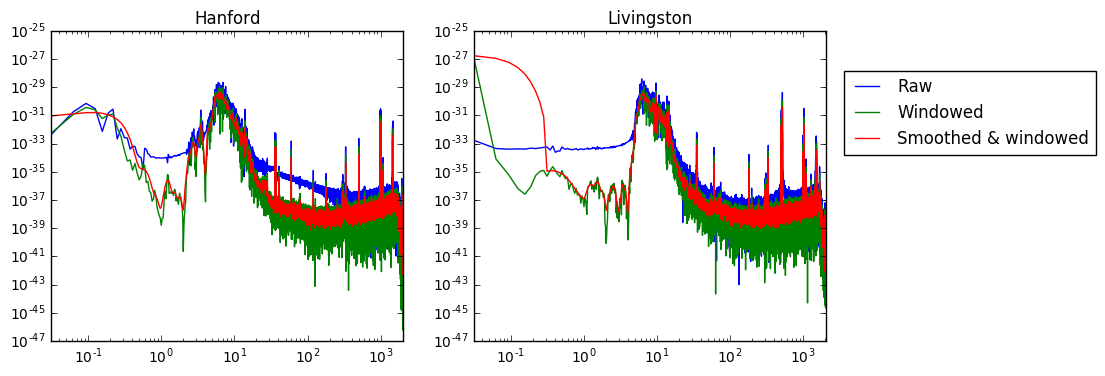

In [7]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.title('Hanford')
plt.loglog(freq, noise_H)
plt.loglog(freq, noise_H_win)
plt.loglog(freq, noise_H_smooth)
plt.xlim(freq[0],freq[-1])
plt.ylim(1e-47,1e-25)

plt.subplot(1,2,2)
plt.title('Livingston')
plt.loglog(freq, noise_L)
plt.loglog(freq, noise_L_win)
plt.loglog(freq, noise_L_smooth)
plt.xlim(freq[0],freq[-1])
plt.ylim(1e-47,1e-25)
plt.legend(['Raw','Windowed','Smoothed & windowed'], loc=(1.05,0.6))
plt.show()

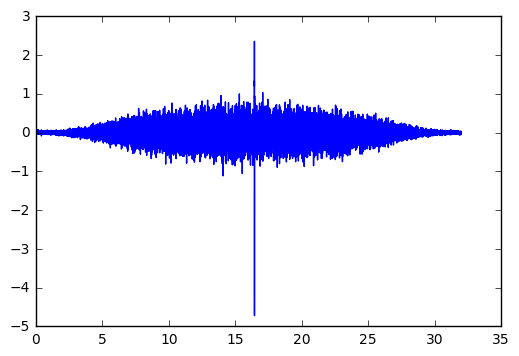

In [9]:
strain_H_white = np.fft.rfft(strain_H_win)/np.sqrt(noise_H_smooth)
th_white = np.fft.rfft(th)/np.sqrt(noise_H_smooth)


match_filter = np.fft.irfft(np.conj(th_white)*strain_H_white)
time = np.fft.fftfreq(len(strain_H_win), samp)*len(strain_H)

plt.plot((time-np.min(time)), match_filter)
plt.show()

In [ ]:
# m = (A.T*Ninv*d)*(A.T*Ninv*A)^-1

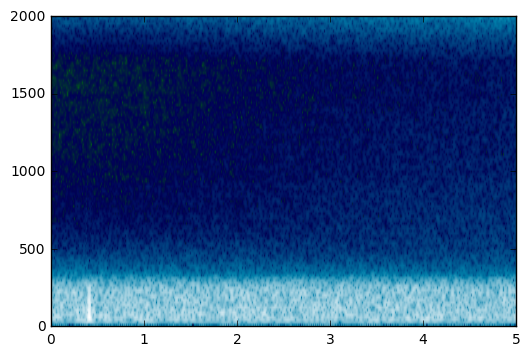

In [201]:
plt.specgram(match_filter, Fs=samp, NFFT=int(samp/16), noverlap=int(samp*15/16**2), cmap='ocean')
plt.axis([0,5,0,2000])
plt.show()

In [35]:
# Use the power spectral density of each instrument as the respective noise model
# noise_H = np.abs(np.fft.rfft(strain_H*np.hanning(len(strain_H))))**2
# noise_L = np.abs(np.fft.rfft(strain_L*np.hanning(len(strain_L))))**2

# Convert the time axis to Fourier space using np.fft.rfftfreq()
# freq = np.fft.rfftfreq(len(strain_H), dt)

# Use Welch's method to get the power spectral density (PSD) of the Hanford and Livingston data.
# Consider the PSD to be the noise model for its respective instrument.
# Welch's method smooths the noise model by averaging overlapping segments of the data.
NFFT = 4*samp # use 4 seconds of data for each fourier transform
n_overlap = NFFT/2 # overlap half the points
# Use a Hanning window along with Welch's method:
freq, noise_avg_H = signal.welch(strain_H, fs=samp, nfft=NFFT, window='hanning', noverlap=n_overlap, nperseg=NFFT) 
freq, noise_avg_L = signal.welch(strain_L, fs=samp, nfft=NFFT, window='hanning', noverlap=n_overlap, nperseg=NFFT)

freq_nowelch, noise_H = signal.periodogram(strain_H, fs=samp, nfft=NFFT, window='hanning')
freq_nowelch, noise_L = signal.periodogram(strain_L, fs=samp, nfft=NFFT, window='hanning')

[]

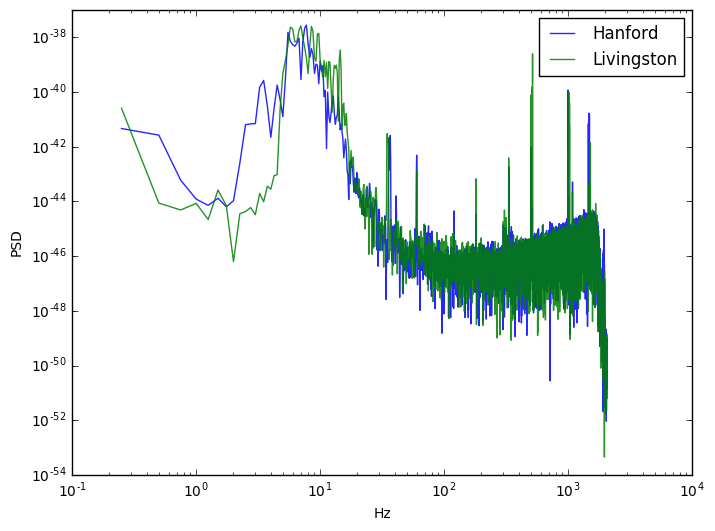

In [37]:
plt.figure(figsize=(8,6))

plt.loglog(freq_nowelch, noise_H, label='Hanford', alpha=0.85)
plt.loglog(freq_nowelch, noise_L, label='Livingston', alpha=0.85)

# plt.grid(which='both')
plt.xlabel('Hz')
plt.ylabel('PSD')
# plt.xlim(10,1600)
plt.legend()
plt.plot()

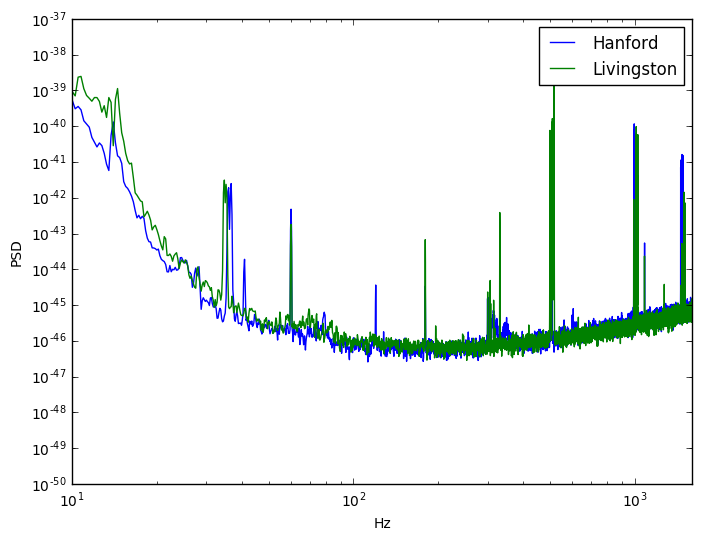

In [11]:
plt.figure(figsize=(8,6))

plt.loglog(freq, noise_avg_H, label='Hanford')
plt.loglog(freq, noise_avg_L, label='Livingston')

# plt.grid(which='both')
plt.xlabel('Hz')
plt.ylabel('PSD')
plt.xlim(10,1600)
plt.legend()

In [12]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    num = len(strain)
    # Take the Fourier transform of the data
    freq = np.fft.rfftfreq(num, dt)

    # Whitening: transform to frequency domain, divide by srqt of PSD, then transform back, taking care of the normalization right
    strain_ft = np.fft.rfft(strain)

    # Apply time and phase shift
    strain_ft = strain_ft*np.exp(-1.0j*2*np.pi*time_shift*freq - 1.0j*phase_shift)
    norm = 1.0/np.sqrt(0.5/dt)
    white_ft = norm*strain_ft/np.sqrt(interp_psd(freq))
    white = np.fft.irfft(white_ft, n=num)
    return white

def bandpass(strain, fband, fs):
    b, a = signal.butter(4, [fband[0]*2/fs, fband[1]*2/fs], btype='bandpass') # Design a Butterworth bandpass filter
    normalization = np.sqrt(2*(fband[1]-fband[0])/fs)
    strain_bp = signal.filtfilt(b, a, strain)/normalization # Apply the bandpass filter to the data
    return strain_bp

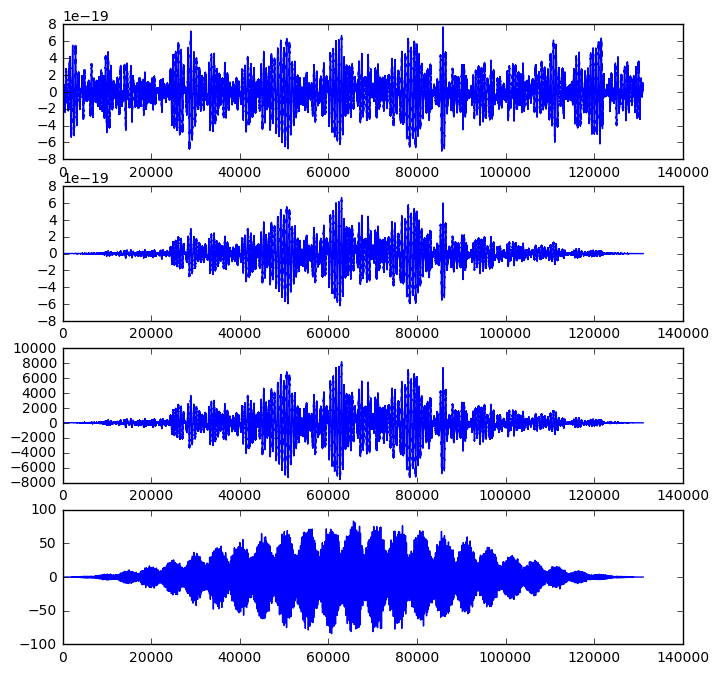

In [13]:
fband = [35, 350]

PSD_interp_H = interpolate.interp1d(freq, noise_avg_H)
PSD_interp_L = interpolate.interp1d(freq, noise_avg_L)

# window_len = 32*samp
# dwindow = signal.hann(len(strain_H))

strain_windowed_H = strain_H*signal.hann(len(strain_H))
strain_whitened_H = whiten(strain_windowed_H, PSD_interp_H, samp)
strain_bp_H = bandpass(strain_whitened_H, fband, samp)

plt.figure(figsize=(8,8))

plt.subplot(4, 1, 1)
plt.plot(strain_H)

plt.subplot(4, 1, 2)
plt.plot(strain_windowed_H)

plt.subplot(4, 1, 3)
plt.plot(strain_whitened_H)

plt.subplot(4, 1, 4)
plt.plot(strain_bp_H)